In [1]:
"""
This code performs graph classification with a simple Graph Convolutional Neural Network based on Spektral
So far no graphic card needed and it only works on woodycap
"""

#import random #for shuffling lists
import spektral as spektral #package based on Keras that is foundation for GNNs
import tables #show h5 files hirarchy
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12}) #change font size of diagrams
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #for compatability?
import pandas as pd

import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #show number of GPUs


from spektral.datasets import TUDataset #example dataset (molecules?)
from spektral.layers import GINConv, GlobalAvgPool, GCNConv, GlobalSumPool, GCSConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader #Dataset to create a custom dataset
from spektral.transforms.normalize_adj import NormalizeAdj

from ctapipe.visualization import CameraDisplay #for visualisation of hexagonal pixel plots
from ctapipe.io import EventSource
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.instrument import CameraGeometry #for obtaining adjacency matrix of the camera

#this code makes Nvidia RTX3080 also compatible with the code
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-04-06 00:33:27.101124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 00:33:27.101180: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Num GPUs Available:  0


2022-04-06 00:33:40.451176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 00:33:40.451222: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 00:33:40.451254: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (woodycap4): /proc/driver/nvidia/version does not exist
2022-04-06 00:33:46.605437: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
channels = 128  # Hidden units
layers = 3  # GIN layers
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

################################################################################
# Load data
################################################################################
dataset = TUDataset("PROTEINS", clean=True)

# Parameters
F = dataset.n_node_features  # Dimension of node features (here it is 4)
n_out = dataset.n_labels  # Dimension of the target (here 2)


print(dataset)
print(type(dataset))
print(dataset[1])



# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)


################################################################################
# Build model
################################################################################
class GIN0(Model):
    def __init__(self, channels, n_layers):
        super().__init__()
        self.conv1 = GINConv(channels, epsilon=0, mlp_hidden=[channels, channels])
        self.convs = []
        for _ in range(1, n_layers):
            self.convs.append(
                GINConv(channels, epsilon=0, mlp_hidden=[channels, channels])
            )
        self.pool = GlobalAvgPool()
        self.dense1 = Dense(channels, activation="relu")
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(n_out, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool([x, i])
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)


# Build model
model = GIN0(channels, layers)
optimizer = Adam(learning_rate)
loss_fn = CategoricalCrossentropy()


################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


epoch = step = 0
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1
        print("Ep. {} - Loss: {}. Acc: {}".format(epoch, *np.mean(results, 0)))
        results = []

################################################################################
# Evaluate model
################################################################################
results = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    results.append(
        (
            loss_fn(target, predictions),
            tf.reduce_mean(categorical_accuracy(target, predictions)),
        )
    )
print("Done. Test loss: {}. Test acc: {}".format(*np.mean(results, 0)))

In [2]:
#load event data of gammas (and later also protons) (DL1.h5) as h5 data containers

file = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/gamma_20deg_0deg_run7239___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5"
file_proton = "/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/proton_20deg_0deg_run4386___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5"

h5file = tables.open_file(file, driver="H5FD_CORE")
protons = tables.open_file(file_proton, driver="H5FD_CORE")

print(h5file)


/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_gamma-diffuse_North_20deg_ctapipe_v0.10.5_DL1/gamma_20deg_0deg_run7239___cta-prod5-paranal_desert-2147m-Paranal-dark_cone10_merged.DL1.h5 (File) ''
Last modif.: 'Tue Nov 23 19:51:34 2021'
Object Tree: 
/ (RootGroup) ''
/configuration (Group) ''
/dl1 (Group) ''
/simulation (Group) ''
/simulation/event (Group) ''
/simulation/service (Group) ''
/simulation/service/shower_distribution (Table(5,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of SimulatedShowerDistribution'
/simulation/event/subarray (Group) ''
/simulation/event/subarray/shower (Table(5436,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of EventIndexContainer,SimulatedShowerContainer'
/simulation/event/telescope (Group) ''
/simulation/event/telescope/images (Group) ''
/simulation/event/telescope/images/tel_001 (Table(394,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,SimulatedCameraContainer'
/simulation/event/telesco

In [3]:
#overview of the loaded h5 data and a few subfolders

#command: shows subgroup names: ._g_getnchildren
#command: print(h5file.root.dl1.event.telescope.images._f_iter_nodes) iterate over all nodes=subtables in the group
print(h5file.root.dl1.event.telescope.images.tel_001)
print(h5file.root.dl1.event.telescope.images.tel_001.description)
print(h5file.root.dl1.event.telescope.images.tel_001.cols)
print(h5file.root.dl1.event.telescope.images.tel_001.nrows)
print(np.array(h5file.root.dl1.event.telescope.images.tel_001.col("image")).shape)
#print(np.array(h5file.root.dl1.event.telescope.images.tel_001.col("image"))[5,:]) #show one image

print("\n")

#this seems to be DL2 data format (whatever that means), these are not the relevant training images
print(h5file.root.simulation.event.telescope.images.tel_001)
print(h5file.root.simulation.event.telescope.images.tel_001.description)
print(h5file.root.simulation.event.telescope.images.tel_001.cols)
print(h5file.root.simulation.event.telescope.images.tel_001.nrows)
print(np.array(h5file.root.simulation.event.telescope.images.tel_001.col("true_image")).shape)

#show geometry of the cams (all of them at the end of print(h5file))
print("\n")
print(h5file.root.configuration.instrument.telescope.camera.geometry_LSTCam.description)
print(h5file.root.configuration.instrument.telescope.camera.geometry_LSTCam.nrows)


/dl1/event/telescope/images/tel_001 (Table(394,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,DL1CameraContainer'
Description([('obs_id', '()i4'), ('event_id', '()i8'), ('tel_id', '()i2'), ('image', '(1855,)i4'), ('peak_time', '(1855,)i2'), ('image_mask', '(1855,)b1')])
/dl1/event/telescope/images/tel_001.cols (Cols), 6 columns
394
(394, 1855)


/simulation/event/telescope/images/tel_001 (Table(394,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,SimulatedCameraContainer'
Description([('obs_id', '()i4'), ('event_id', '()i8'), ('tel_id', '()i2'), ('true_image', '(1855,)i4')])
/simulation/event/telescope/images/tel_001.cols (Cols), 4 columns
394
(394, 1855)


Description([('pix_id', '()i8'), ('pix_x', '()f8'), ('pix_y', '()f8'), ('pix_area', '()f8')])
1855


In [4]:
print(protons)
print(np.array(protons.root.dl1.event.telescope.images.tel_001.col("image")).shape)

/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_Paranal_AdvancedBaseline_NSB1x_proton_North_20deg_ctapipe_v0.10.5_DL1/proton_20deg_0deg_run4386___cta-prod5-paranal_desert-2147m-Paranal-dark_merged.DL1.h5 (File) ''
Last modif.: 'Tue Nov 23 20:53:35 2021'
Object Tree: 
/ (RootGroup) ''
/configuration (Group) ''
/dl1 (Group) ''
/simulation (Group) ''
/simulation/event (Group) ''
/simulation/service (Group) ''
/simulation/service/shower_distribution (Table(5,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of SimulatedShowerDistribution'
/simulation/event/subarray (Group) ''
/simulation/event/subarray/shower (Table(2657,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of EventIndexContainer,SimulatedShowerContainer'
/simulation/event/telescope (Group) ''
/simulation/event/telescope/images (Group) ''
/simulation/event/telescope/images/tel_001 (Table(194,), fletcher32, shuffle, blosc:zstd(5)) 'Storage of TelEventIndexContainer,SimulatedCameraContainer'
/simulation/event/telescope/images/tel

[[False  True False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False  True  True]
 [False False False ...  True False False]
 [False False False ...  True False False]]


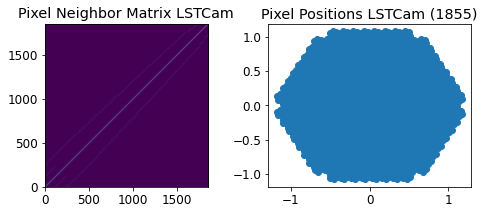

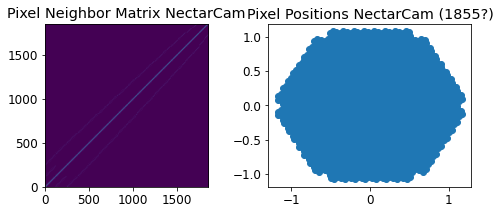

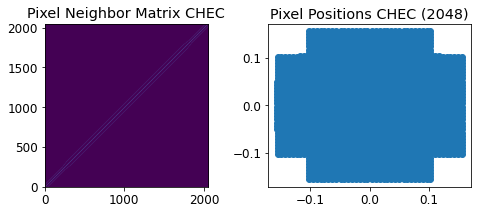

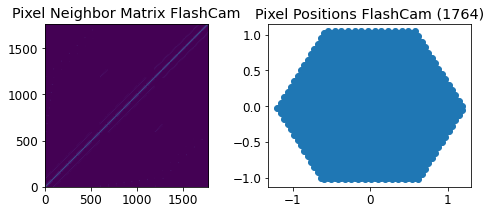

In [5]:
#plot adjacency matrix of given geometry in input file using ctapipe
geom = CameraGeometry.from_name("LSTCam") #geometry of LST camera

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower") #geom.neighbor_matrix is the adjacency matrix
plt.title("Pixel Neighbor Matrix LSTCam") #adjacency matrix for LST camera

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions LSTCam (1855)")


geom = CameraGeometry.from_name("NectarCam") #geometry that looks like LST camera

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix NectarCam")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions NectarCam (1855?)")



geom = CameraGeometry.from_name("CHEC") #???

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix CHEC")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions CHEC (2048)")


geom = CameraGeometry.from_name("FlashCam") #???

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(geom.neighbor_matrix, origin="lower")
plt.title("Pixel Neighbor Matrix FlashCam")

plt.subplot(1, 2, 2)
plt.scatter(geom.pix_x, geom.pix_y)
plt.title("Pixel Positions FlashCam (1764)")

print(geom.neighbor_matrix) #adjacency matrix for one camera

In [6]:
#this path is DL1 data
#collect gamma images from all telescope types and putting it to a list called images
tel = h5file.root.dl1.event.telescope.images._f_iter_nodes()
images = []
for tel in tel:
    images.append(tel.col("image"))

print(len(images))
print(images) #images contains ~180 telescope folders (LST, FlashCam,...) with few hundred images each



#collect proton images from all telescope types and putting it to a list called images_proton
tel_proton = protons.root.dl1.event.telescope.images._f_iter_nodes()
images_proton = []
for tel_proton in tel_proton:
    images_proton.append(tel_proton.col("image"))

print(images_proton) #images contains ~180 telescope folders (LST, FlashCam,...) with few hundred images each
print(len(images_proton)) #also 180 events

180
[array([[ 13,   2,   5, ...,  -6,  26,  14],
       [ -1,  -1,   8, ...,   1, -19,   6],
       [ -3,   3,   4, ...,  -5, -15, -14],
       ...,
       [-11, -18,   8, ...,   8, -14,  -3],
       [ 12,   5,  -6, ...,  91,   6, -16],
       [ -7,  -9,  17, ..., -13, -16,   7]], dtype=int32), array([[-15,  -1, -13, ..., -19,   1, -10],
       [-20,   0,  -7, ...,   1,  -1,  12],
       [-15,  10, -16, ..., -13,  -7,  16],
       ...,
       [  2,  -7,   1, ..., 109,  12,  -6],
       [  5,   1,   9, ...,   9, -11,  -7],
       [ -3,   0, -13, ...,   0,  11,  35]], dtype=int32), array([[ -3,  18, -15, ...,  -1,  -6,  -5],
       [  4, -11,   6, ...,   4,  55,  -3],
       [ -3,   3,   6, ...,  -7,  -8,   9],
       ...,
       [ 59,  18, -15, ...,  12, -10,   9],
       [  3, -16,  13, ...,  -2,  -5,  27],
       [ 29,  14,   7, ...,  -7,  -9,  -3]], dtype=int32), array([[ -4, -12,  16, ...,  -3, -16,  -6],
       [ -3,  -8,   9, ...,   0,   4,   1],
       [ 18,  -4,  -9, ..., -14,  

[array([[  1,   6,  25, ...,   4,  14,  14],
       [-10,   7,   1, ..., -13,  16,   2],
       [  9,  64,  30, ...,  23,   7,  16],
       ...,
       [ -1,  -5,  10, ..., -10,   5, -21],
       [  1,   7,   2, ...,  -3, -11, -12],
       [ -4,   1,  20, ..., -14,  10, -18]], dtype=int32), array([[  3,   5,  -3, ..., -11,  -5,  -5],
       [  1,  20,   9, ...,  40,  -9,  13],
       [  0,  -1,  23, ..., -20,  -7,  -9],
       ...,
       [-12, -15,  12, ...,  -4,  -7,  -6],
       [-21,  -3,  21, ..., -14,  -2,  -1],
       [ 17,  18, -10, ...,   3,  -6,  -7]], dtype=int32), array([[  2,  15,   2, ...,  -7,  -5,   9],
       [ 12, -19,  -9, ...,   0,  27,  22],
       [ -9,  -3,   3, ...,  31, -11,  -8],
       ...,
       [-14, -16,  -9, ...,  -6,   2,   3],
       [  7,  -9,  -2, ..., -16,  -4,  -7],
       [-21,  -5,   0, ...,  -6,  20, -18]], dtype=int32), array([[  3, -11,   0, ...,   2,  -5,  32],
       [ 13, -12,   7, ...,  20,   8,  14],
       [-10,   0, -18, ...,  20,  -2, 

In [7]:
'this codeblock is redundant if one only wants LST images with 1855 pixels'

print(np.array(images[7]).shape) #one element meaning one telescope camera type (for example LST, FlashCam,...) has this shape
print(np.array(images[7])[11,:]) #list of pixel values (in photoelectrons?) of one specific image 11 from one specific telescope camera 7


#collect geometries for all 180 entries of telescope camera types (for example LST, FlashCam,...)
geometries = []

#collect adjacency matrix for every telescope camera depending on the number of pixels of the camera
for i in range(len(images)):
    if np.ma.size(np.array(images[i]), axis = 1) == 1855:
        geometries.append(CameraGeometry.from_name("LSTCam").neighbor_matrix)
    elif np.ma.size(np.array(images[i]), axis = 1) == 2048:
        geometries.append(CameraGeometry.from_name("CHEC").neighbor_matrix)
    elif np.ma.size(np.array(images[i]), axis = 1) == 1764:
        geometries.append(CameraGeometry.from_name("FlashCam").neighbor_matrix)
    else:
        Print("Something went wrong")


print(len(geometries))
print(geometries[1]) #adjacency matrix of telescope camera [1]

#now we have images (180 tel with a few hundred images each)
# and also geometries with 180 ajacency matrices

(413, 1764)
[  1 -44   0 ... -36 -13  34]
180
[[False  True  True ... False False False]
 [ True False  True ... False False False]
 [ True  True False ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ...  True False  True]
 [False False False ... False  True False]]


In [8]:
#select only LST gamma images (or at least images with 1855 pixels (do not know the difference so far)) and save tem in images_lst
images_lst_list = []

for i in range(len(images)):
    if np.ma.size(np.array(images[i]), axis = 1) == 1855:
        images_lst_list.append(images[i])
    else:
        pass
    
images_lst = np.empty((0,1855))
for i in range(len(images_lst_list)):
    images_lst = np.concatenate((images_lst, np.array(images_lst_list[i])), axis = 0)
images_lst = images_lst[1:,:] #get rid of numpy empty entry

print("Now gamma image shape is:", images_lst.shape)




#select only LST proton images (or at least images with 1855 pixels (do not know the difference so far)) and save tem in images_lst_proton
images_lst_proton_list = []

for i in range(len(images_proton)):
    if np.ma.size(np.array(images_proton[i]), axis = 1) == 1855:
        images_lst_proton_list.append(images_proton[i])
    else:
        pass
    
images_lst_proton = np.empty((0,1855))
for i in range(len(images_lst_proton_list)):
    images_lst_proton = np.concatenate((images_lst_proton, np.array(images_lst_proton_list[i])), axis = 0)
images_lst_proton = images_lst_proton[1:,:] #get rid of numpy empty entry

print("Now proton image shape is:", images_lst_proton.shape)




#collect LST geometry
geometrie_lst = CameraGeometry.from_name("LSTCam").neighbor_matrix #this collects LST adjacency matrix
geometrie_lst = geometrie_lst.astype(np.float32) #convert from bool to float for GNN input
print("Now adjacency shape is:", geometrie_lst.shape)
print("\n", geometrie_lst)


Now gamma image shape is: (12621, 1855)
Now proton image shape is: (6700, 1855)
Now adjacency shape is: (1855, 1855)

 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [9]:
#prepare gamma labels for each graph (meaning each image)
labels = np.ones(np.size(images_lst, 0))
print(labels.shape) #12621 times number one as the target value

#prepare proton labels for each graph (meaning each image)
labels_proton = np.zeros(np.size(images_lst_proton, 0))
print(labels_proton.shape) #12621 times number one as the target value

(12621,)
(6700,)


In [10]:
#merging proton and gamma images and labels
labels = np.concatenate((labels,labels_proton))
images_lst = np.concatenate((images_lst, images_lst_proton))
print(labels.shape)
print(images_lst.shape)


(19321,)
(19321, 1855)


In [11]:
# spektral custom dataset class so one transforms numpy arrays to Spektral datasets (for GNN input)
class MyDataset(Dataset): #in brackets one puts inherited classes
    """
    A dataset created by a numpy array of images of shape (number_of_images, number_of_pixels) and
    by a numpy array of labels of shape (number_of_images)
    """
    def __init__(self, images, labels, **kwargs): #initiate instance
        self.images = images
        self.labels = labels
        super().__init__(**kwargs) #inherit from other classes
        
    def read(self): #this function returns a list of graph objects so that Spektral takes it as the GNNs input
        # We must return a list of Graph objects
        output = []

        for i in range(np.size(self.labels)): #do for all training images
            output.append(spektral.data.graph.Graph(x = self.images[i,:], a = geometrie_lst, y = self.labels[i]))

        return output

#create a new instance from the class Dataset
dataset = MyDataset(images_lst[:,:], labels[:]) #, transforms=NormalizeAdj() #this takes a lot of ram
input_gnn = dataset.read() #write down a list of graph objects calling a class method of the instance

print(dataset) #this only gives position in RAM space
print(type(dataset))
print(dataset[3])
print()

print(input_gnn[10:13])
print(type(input_gnn))
print(input_gnn[4])
print(len(input_gnn))

MyDataset(n_graphs=19321)
<class '__main__.MyDataset'>
Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)

[Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1), Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1), Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)]
<class 'list'>
Graph(n_nodes=1855, n_node_features=1, n_edge_features=None, n_labels=1)
19321


/home/hpc/caph/mppi109h/miniconda3/envs/cuda11-gnn/lib/python3.8/site-packages/spektral/data/graph.py:67: UserWarning: x was automatically reshaped to (1855, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")


In [12]:
#create GNN
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden, activation="relu") #A graph convolutional layer where n_hidden is number of channels
        self.pool = GlobalSumPool() #graph pooling layer
        self.graph_conv = GCNConv(n_hidden, activation="relu")
        self.dropout = Dropout(0.1) #original was 0.5
        self.dense = Dense(n_labels, 'sigmoid') #original sofmax function

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [13]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(dataset.n_labels, activation="sigmoid")

    def call(self, inputs):
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool(x)
        output = self.dense(output)

        return output

In [14]:
#define strategy for splitting training over multiple GPUs #does not work currently
strategy = tf.distribute.MirroredStrategy(devices=None) #devices=None automatically detects all devices
print('Number of devices: {}'.format(strategy.num_replicas_in_sync)) #show number of devices for training

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [15]:
#compile model
model = Net() #first number = number of channels #original was 32
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(from_logits=True)])

#load dater using batch-loader for fitting the model
loader = BatchLoader(dataset, batch_size=32, shuffle=True)

model.fit(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=50)


"""

loss2=tf.keras.losses.BinaryCrossentropy(from_logits=True)
#compile model
model2 = MyFirstGNN(32, dataset.n_labels) #first number = number of channels #original was 32
model2.compile(optimizer="SGD", loss=loss2, metrics=["sparse_categorical_accuracy"])

#load dater using batch-loader for fitting the model
loader2 = BatchLoader(dataset, batch_size=32, shuffle=True)

model2.fit(loader2.load(), steps_per_epoch=loader2.steps_per_epoch, epochs=10)




loss3 = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,axis=-1,reduction="auto",
name="categorical_crossentropy")

#compile model
model3 = MyFirstGNN(32, dataset.n_labels) #first number = number of channels #original was 32
model3.compile(optimizer="SGD", loss=loss3, metrics=["sparse_categorical_accuracy"])

#load dater using batch-loader for fitting the model
loader3 = BatchLoader(dataset, batch_size=32, shuffle=True)

model3.fit(loader3.load(), steps_per_epoch=loader3.steps_per_epoch, epochs=10)
"""

Epoch 1/50
604/604 [==============================] - 582s 961ms/step - loss: 4.0859 - auc: 0.5052
Epoch 2/50
604/604 [==============================] - 586s 970ms/step - loss: 4.0090 - auc: 0.5066
Epoch 3/50
604/604 [==============================] - 583s 965ms/step - loss: 2.5070 - auc: 0.5116
Epoch 4/50
604/604 [==============================] - 582s 964ms/step - loss: 1.7548 - auc: 0.5142
Epoch 5/50
604/604 [==============================] - 588s 974ms/step - loss: 1.1555 - auc: 0.5167
Epoch 6/50
604/604 [==============================] - 587s 971ms/step - loss: 1.1051 - auc: 0.5271
Epoch 7/50
604/604 [==============================] - 588s 973ms/step - loss: 1.0161 - auc: 0.5141
Epoch 8/50
604/604 [==============================] - 589s 975ms/step - loss: 1.0188 - auc: 0.5179
Epoch 9/50
604/604 [==============================] - 588s 973ms/step - loss: 0.7333 - auc: 0.5226
Epoch 10/50
604/604 [==============================] - 585s 968ms/step - loss: 0.7370 - auc: 0.5141
Epoch 11/

'\n\nloss2=tf.keras.losses.BinaryCrossentropy(from_logits=True)\n#compile model\nmodel2 = MyFirstGNN(32, dataset.n_labels) #first number = number of channels #original was 32\nmodel2.compile(optimizer="SGD", loss=loss2, metrics=["sparse_categorical_accuracy"])\n\n#load dater using batch-loader for fitting the model\nloader2 = BatchLoader(dataset, batch_size=32, shuffle=True)\n\nmodel2.fit(loader2.load(), steps_per_epoch=loader2.steps_per_epoch, epochs=10)\n\n\n\n\nloss3 = tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.0,axis=-1,reduction="auto",\nname="categorical_crossentropy")\n\n#compile model\nmodel3 = MyFirstGNN(32, dataset.n_labels) #first number = number of channels #original was 32\nmodel3.compile(optimizer="SGD", loss=loss3, metrics=["sparse_categorical_accuracy"])\n\n#load dater using batch-loader for fitting the model\nloader3 = BatchLoader(dataset, batch_size=32, shuffle=True)\n\nmodel3.fit(loader3.load(), steps_per_epoch=loader3.steps_per_epoch

In [16]:
#checking layers and gnn structure
#commit to github

In [17]:
model.summary()

#evaluate the model on an unseen test set using a different loader
loader_test = BatchLoader(test_dataset, batch_size=32, shuffle=True)
loss = model.evaluate(loader_test.load(), steps=loader_test.steps_per_epoch)

print('Test loss: {}'.format(loss))


Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcs_conv (GCSConv)          multiple                  96        
                                                                 
 gcs_conv_1 (GCSConv)        multiple                  2080      
                                                                 
 gcs_conv_2 (GCSConv)        multiple                  2080      
                                                                 
 global_avg_pool (GlobalAvgP  multiple                 0         
 ool)                                                            
                                                                 
 dense (Dense)               multiple                  33        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_____________________________________________________________

NameError: name 'test_dataset' is not defined

In [ ]:
"""
This example shows how to define your own dataset and use it to train a
non-trivial GNN with message-passing and pooling layers.
The script also shows how to implement fast training and evaluation functions
in disjoint mode, with early stopping and accuracy monitoring.
The dataset that we create is a simple synthetic task in which we have random
graphs with randomly-colored nodes. The goal is to classify each graph with the
color that occurs the most on its nodes. For example, given a graph with 2
colors and 3 nodes:
x = [[1, 0],
     [1, 0],
     [0, 1]],
the corresponding target will be [1, 0].
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.transforms.normalize_adj import NormalizeAdj

################################################################################
# Config
################################################################################
learning_rate = 1e-2  # Learning rate
epochs = 10  # Number of training epochs
es_patience = 10  # Patience for early stopping
batch_size = 32  # Batch size


################################################################################
# Load data
################################################################################
class MyDataset(Dataset):
    """
    A dataset of random colored graphs.
    The task is to classify each graph with the color which occurs the most in
    its nodes.
    The graphs have `n_colors` colors, of at least `n_min` and at most `n_max`
    nodes connected with probability `p`.
    """

    def __init__(self, n_samples, n_colors=3, n_min=10, n_max=100, p=0.1, **kwargs):
        self.n_samples = n_samples
        self.n_colors = n_colors
        self.n_min = n_min
        self.n_max = n_max
        self.p = p
        super().__init__(**kwargs)

    def read(self):
        def make_graph():
            n = np.random.randint(self.n_min, self.n_max)
            colors = np.random.randint(0, self.n_colors, size=n)

            # Node features
            x = np.zeros((n, self.n_colors))
            x[np.arange(n), colors] = 1

            # Edges
            a = np.random.rand(n, n) <= self.p
            a = np.maximum(a, a.T).astype(int)
            a = sp.csr_matrix(a)

            # Labels
            y = np.zeros((self.n_colors,))
            color_counts = x.sum(0)
            y[np.argmax(color_counts)] = 1

            return Graph(x=x, a=a, y=y)

        # We must return a list of Graph objects
        return [make_graph() for _ in range(self.n_samples)]


data = MyDataset(1000, transforms=NormalizeAdj())

print("This is the same type of dataset as mine above:")
print(data)
print(type(data))
print(data[3])

# Train/valid/test split
idxs = np.random.permutation(len(data))
split_va, split_te = int(0.8 * len(data)), int(0.9 * len(data))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = data[idx_tr]
data_va = data[idx_va]
data_te = data[idx_te]

# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size)
loader_te = DisjointLoader(data_te, batch_size=batch_size)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(32, activation="relu")
        self.conv2 = GCSConv(32, activation="relu")
        self.conv3 = GCSConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(data.n_labels, activation="softmax")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)
loss_fn = CategoricalCrossentropy()


################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1

        # Compute validation loss and accuracy
        val_loss, val_acc = evaluate(loader_va)
        print(
            "Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Val loss: {:.3f} - Val acc: {:.3f}".format(
                epoch, *np.mean(results, 0), val_loss, val_acc
            )
        )

        # Check if loss improved for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(val_loss))
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
        results = []

################################################################################
# Evaluate model
################################################################################
model.set_weights(best_weights)  # Load best model
test_loss, test_acc = evaluate(loader_te)
print("Done. Test loss: {:.4f}. Test acc: {:.2f}".format(test_loss, test_acc))